In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'])


In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_j = sales_j.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_j.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,63722,238469,164221
1,2019-02-01,76987,288111,198407
2,2019-03-01,99645,372905,256800
3,2019-04-01,68529,256458,176610
4,2019-05-01,45119,168850,116279


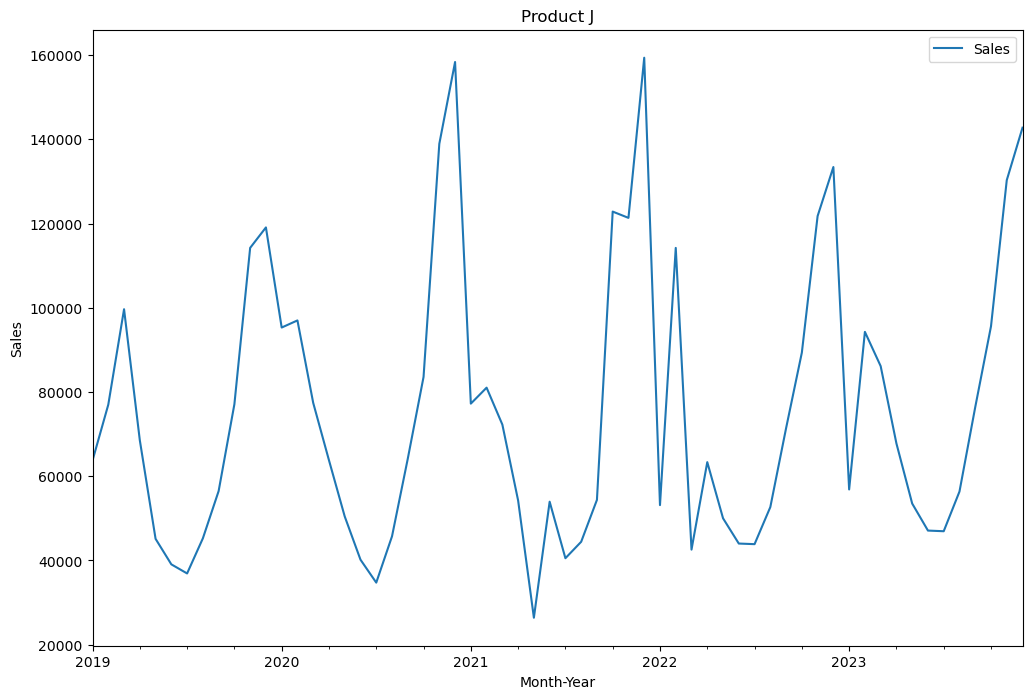

In [5]:
ax = sales_j.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product J')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_j[:57]
test=sales_j[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

13:07:37 - cmdstanpy - INFO - Chain [1] start processing
13:07:37 - cmdstanpy - INFO - Chain [1] done processing
13:07:40 - cmdstanpy - INFO - Chain [1] start processing
13:07:40 - cmdstanpy - INFO - Chain [1] done processing
13:07:44 - cmdstanpy - INFO - Chain [1] start processing
13:07:44 - cmdstanpy - INFO - Chain [1] done processing
13:07:49 - cmdstanpy - INFO - Chain [1] start processing
13:07:49 - cmdstanpy - INFO - Chain [1] done processing
13:07:53 - cmdstanpy - INFO - Chain [1] start processing
13:07:53 - cmdstanpy - INFO - Chain [1] done processing
13:08:00 - cmdstanpy - INFO - Chain [1] start processing
13:08:00 - cmdstanpy - INFO - Chain [1] done processing
13:08:04 - cmdstanpy - INFO - Chain [1] start processing
13:08:05 - cmdstanpy - INFO - Chain [1] done processing
13:08:09 - cmdstanpy - INFO - Chain [1] start processing
13:08:09 - cmdstanpy - INFO - Chain [1] done processing
13:08:13 - cmdstanpy - INFO - Chain [1] start processing
13:08:13 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   16749.403026  
1   18749.313718  
2   15509.536537  
3   15322.068765  
4   15406.819305  
..       

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
51,0.300,0.10,multiplicative,14922.721883
39,0.200,0.10,multiplicative,14964.060532
33,0.100,5.00,multiplicative,14980.939576
27,0.100,0.10,multiplicative,15160.182847
31,0.100,3.00,multiplicative,15170.898690
...,...,...,...,...
70,0.500,10.00,additive,18153.358693
61,0.500,0.01,multiplicative,18467.495838
64,0.500,1.00,additive,18555.738873
1,0.001,0.01,multiplicative,18749.313718


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.3, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.3, seasonality_prior_scale=0.1, seasonality_mode= 'multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

13:28:02 - cmdstanpy - INFO - Chain [1] start processing
13:28:03 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_j['Market Size']
future_dates['Marketing Expense'] = sales_j['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,238469,164221
1,2019-02-01,288111,198407
2,2019-03-01,372905,256800
3,2019-04-01,256458,176610
4,2019-05-01,168850,116279
5,2019-06-01,146172,100661
6,2019-07-01,138085,95092
7,2019-08-01,169281,116575
8,2019-09-01,211288,145504
9,2019-10-01,427430,294350


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,104663.479571,88759.135106,121537.639685
58,2023-11-01,128020.272536,112545.243128,143020.839898
59,2023-12-01,134025.146984,118611.244312,149215.600299


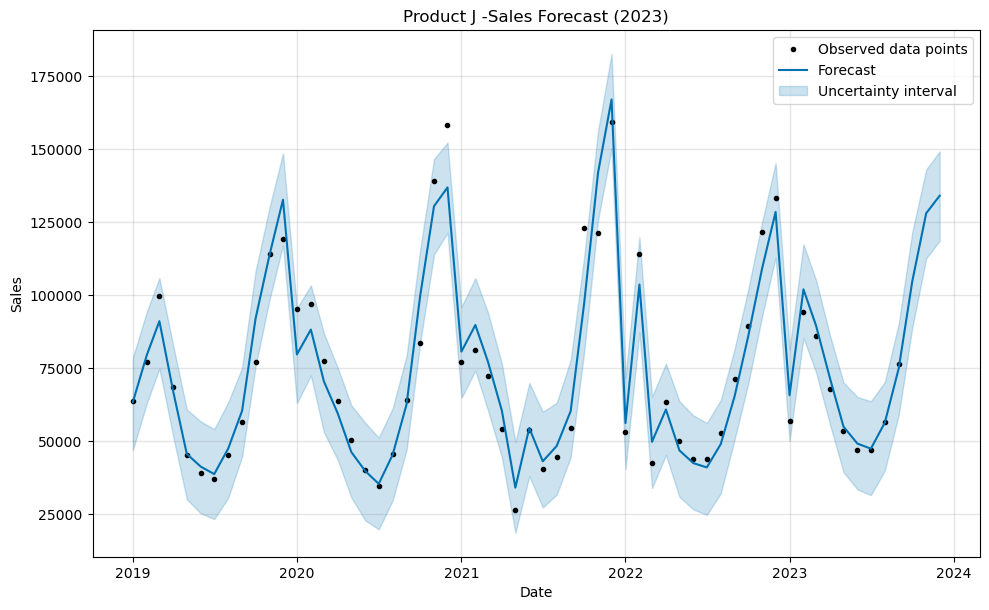

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product J -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

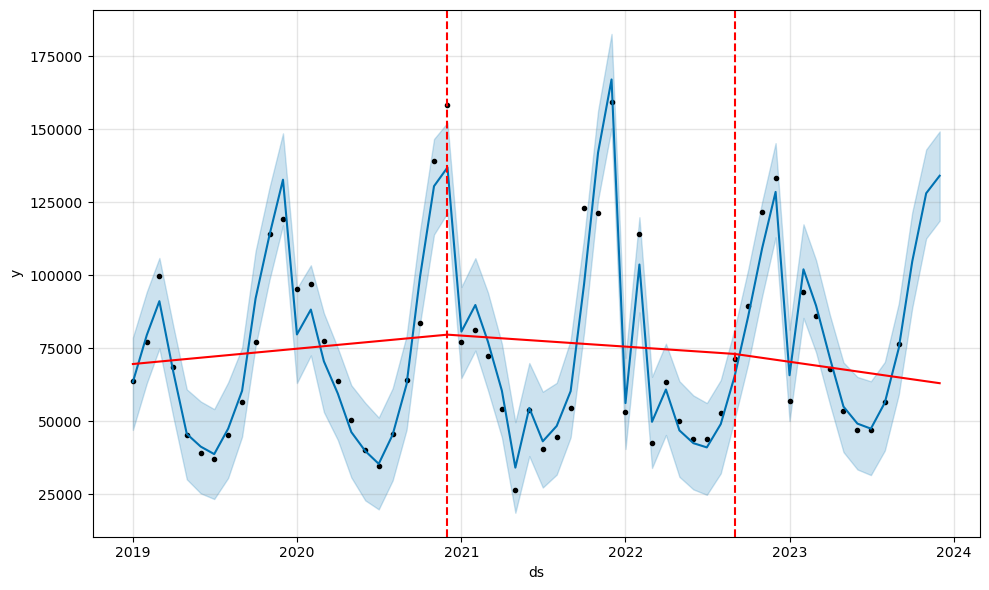

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

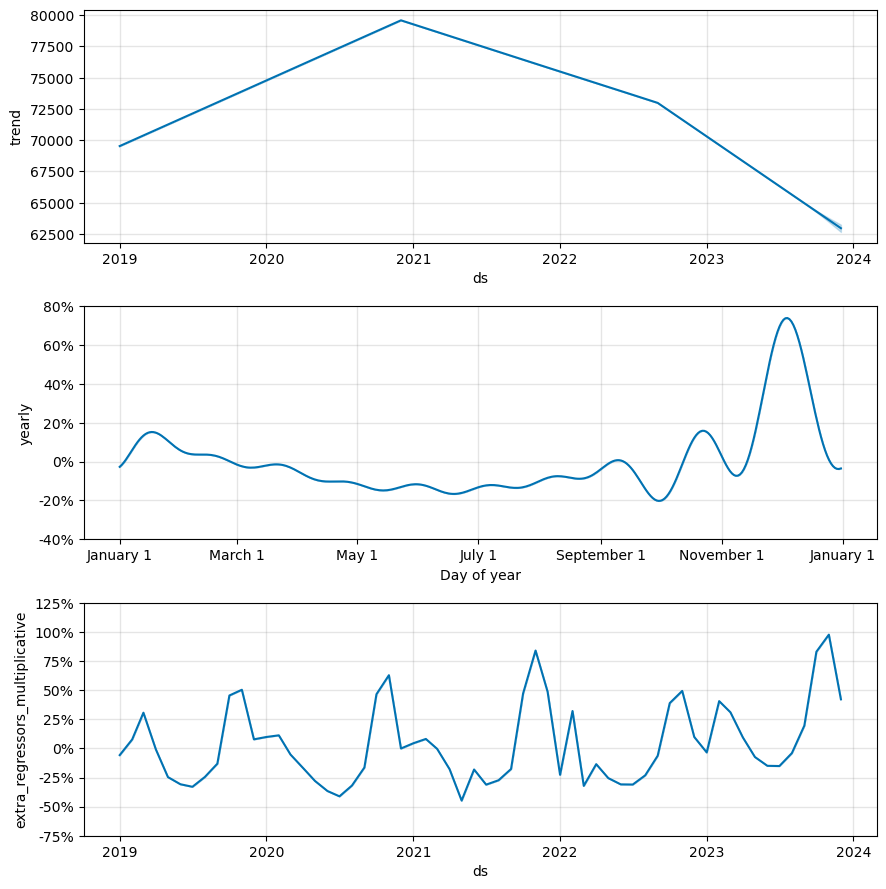

In [21]:
fig2 = model.plot_components(forecast)

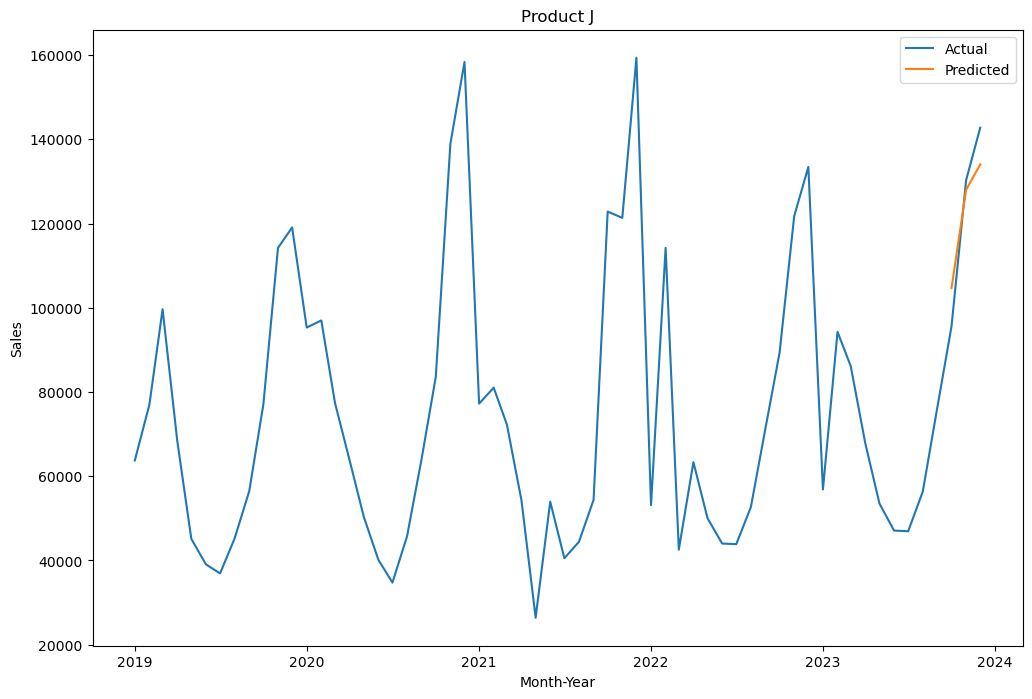

In [22]:
# Reset index of sales_b DataFrame
sales_j_reset_index = sales_j.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_j_reset_index['ds'], sales_j_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product J')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 6690.353
MAPE - FB PROPHET: 0.058
MSE - FB PROPHET: 54537199.679
RMSE - FB PROPHET: 7384.931


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,8.443381e+08,29057.496154,18789.039712,0.176898,0.097039,0.210028,0.666667
1,22 days,8.721642e+08,29532.425526,21672.892673,0.222471,0.145992,0.263340,0.666667
2,23 days,4.707917e+07,6861.426352,6785.542970,0.127561,0.122678,0.136363,1.000000
3,25 days,2.841495e+07,5330.567235,4420.371781,0.085693,0.122678,0.091427,1.000000
4,27 days,1.321664e+08,11496.366809,8620.075815,0.144446,0.099334,0.127331,0.666667
5,28 days,1.323350e+08,11503.696682,8759.947726,0.148752,0.099334,0.131590,0.666667
6,47 days,7.972165e+07,8928.698271,6632.308874,0.157494,0.099334,0.140270,0.833333
7,49 days,1.623479e+07,4029.241629,3313.422635,0.106843,0.062519,0.097543,1.000000
8,51 days,6.101119e+07,7810.965714,6915.432993,0.132990,0.095754,0.122281,1.000000
9,52 days,6.390649e+07,7994.153545,7132.276002,0.099433,0.095754,0.100857,1.000000


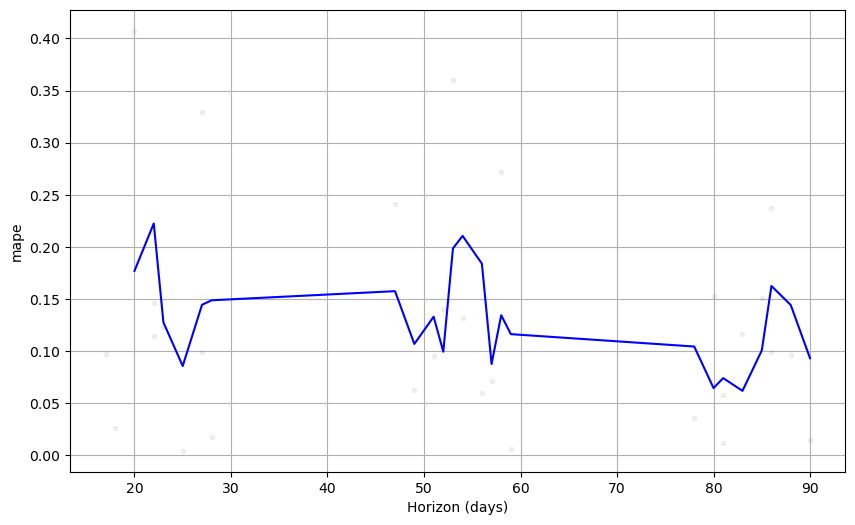

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

57     95597
58    130293
59    142757
Name: y, dtype: int64

In [30]:
pred

57    104663.479571
58    128020.272536
59    134025.146984
Name: yhat, dtype: float64